In [57]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from tqdm import tqdm
import os

# [설정] 파일 경로
RAW_DATA_PATH = "./macro_data_4h/eth_4hour.csv"
LABEL_DATA_PATH = "eth_master_labels_v2.csv"
OUTPUT_PATH = "final_macro_dataset_1.5.csv"

# ==============================================================================
# 1. Stationary Feature Engineering 
# ==============================================================================
def create_stationary_features(df):
    """
    [기능] 비정상성 시계열을 정상성(Stationary) 데이터로 변환
    [보완] TVL 로그 수익률 계산 시 0/NaN 처리 완벽 대응
    """
    df = df.copy()
    
    # 0. 시간 인덱스 설정
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)

    print("1. [Price Action] ETH & BTC 기술적 지표 (비율화)...")
    
    # (1) 수익률 및 변동성
    for coin in ['ETH', 'BTC']:
        c = f"{coin}_Close"
        v = f"{coin}_Volume"
        
        if c not in df.columns: continue
            
        # 로그 수익률 (0으로 나누기 방지)
        prev_close = df[c].shift(1)
        df[f'{coin}_log_ret'] = np.where(
            (df[c] > 0) & (prev_close > 0),
            np.log(df[c] / prev_close),
            0.0
        )
        
        # 변동성 & 거래량 비율
        if f"{coin}_High" in df.columns and f"{coin}_Low" in df.columns:
            atr = df.ta.atr(high=df[f"{coin}_High"], low=df[f"{coin}_Low"], close=df[c], length=14)
            df[f'{coin}_atr_pct'] = atr / df[c]
        
        if v in df.columns:
            vol_ma = df[v].rolling(20).mean()
            df[f'{coin}_vol_ratio'] = df[v] / vol_ma.replace(0, np.nan) 

    # (2) 오실레이터 & 볼린저밴드 
    # RSI
    df['ETH_rsi'] = df.ta.rsi(close=df['ETH_Close'], length=14)
    
    # Bollinger Bands
    bb = df.ta.bbands(close=df['ETH_Close'], length=20, std=2)
    if bb is not None:
        bbl_col = [c for c in bb.columns if c.startswith('BBL')][0]
        bbu_col = [c for c in bb.columns if c.startswith('BBU')][0]
        bbm_col = [c for c in bb.columns if c.startswith('BBM')][0]
        
        # %B (Band Position)
        # 분모가 0인 경우(밴드폭 0) 방지
        denom = bb[bbu_col] - bb[bbl_col]
        df['ETH_bb_pos'] = np.where(denom != 0, (df['ETH_Close'] - bb[bbl_col]) / denom, 0.5)
        
        # Band Width
        df['ETH_bb_width'] = denom / bb[bbm_col]
        
        # Squeeze (조건문이므로 NaN 걱정 없음)
        df['ETH_is_squeeze'] = (df['ETH_bb_width'] < df['ETH_bb_width'].rolling(50).mean() * 0.7).astype(int)
    
    # PPO (MACD %)
    ppo = df.ta.ppo(close=df['ETH_Close'])
    if ppo is not None:
        ppo_col = [c for c in ppo.columns if c.startswith('PPO') and 'h' not in c and 's' not in c][0]
        df['ETH_ppo'] = ppo[ppo_col]
    
    # MFI & CCI
    if 'ETH_High' in df.columns:
        df['ETH_mfi'] = df.ta.mfi(high=df['ETH_High'], low=df['ETH_Low'], close=df['ETH_Close'], volume=df['ETH_Volume'], length=14)
        df['ETH_cci'] = df.ta.cci(high=df['ETH_High'], low=df['ETH_Low'], close=df['ETH_Close'], length=20)

    print("2. [Inter-Market] 김프, 상관계수, 매크로...")
    
    # (3) 김치 프리미엄
    if 'BTC_Bin_Close' in df.columns and 'BTC_Close' in df.columns:
        # 0 나누기 방지
        bin_close = df['BTC_Bin_Close'].replace(0, np.nan)
        df['kimchi_premium'] = (df['BTC_Close'] / bin_close) - 1
    
    # (4) 상관계수 (결측치 허용 -> 나중에 0으로 채움)
    window = 30 * 6 
    targets = ['BTC_Close', 'SP500', 'DXY', 'GOLD', 'VIX']
    for t in targets:
        if t in df.columns:
            s1 = df['ETH_Close'].pct_change()
            s2 = df[t].pct_change()
            df[f'corr_ETH_{t}'] = s1.rolling(window).corr(s2)

    # (5) 매크로 지표
    for col in ['DXY', 'GOLD', 'SP500', 'VIX']:
        if col in df.columns:
            df[f'{col}_pct_change'] = df[col].pct_change()
            ma200 = df[col].rolling(200).mean()
            df[f'{col}_dist_ma200'] = (df[col] / ma200) - 1

    tvl_cols = [c for c in df.columns if 'tvl' in c]
    
    for tvl in tvl_cols:
        curr = df[tvl]
        prev = df[tvl].shift(1)
        

        df[f'{tvl}_change'] = np.where(
            (curr > 1e-9) & (prev > 1e-9),  
            np.log(curr / prev),
            0.0
        )

        df[f'{tvl}_change'] = df[f'{tvl}_change'].replace([np.inf, -np.inf], 0.0)

    # (7) Sentiment
    if 'fundingRate' in df.columns:
        df['funding_rate'] = df['fundingRate']
    if 'fear_greed' in df.columns:
        df['fear_greed_idx'] = df['fear_greed'] / 100.0


    fred_cols = [c for c in df.columns if 'fred_' in c]
    
    features_generated = [
        'ETH_log_ret', 'BTC_log_ret', 'ETH_atr_pct', 'BTC_atr_pct', 
        'ETH_vol_ratio', 'BTC_vol_ratio', 'ETH_rsi', 'ETH_bb_pos', 'ETH_bb_width', 'ETH_is_squeeze',
        'ETH_ppo', 'ETH_mfi', 'ETH_cci', 'kimchi_premium', 'funding_rate', 'fear_greed_idx'
    ]
    features_generated += [c for c in df.columns if 'corr_' in c]
    features_generated += [c for c in df.columns if '_pct_change' in c]
    features_generated += [c for c in df.columns if '_dist_ma200' in c]
    features_generated += [c for c in df.columns if '_change' in c] # TVL change 포함
    features_generated += fred_cols
    

    final_features = [c for c in features_generated if c in df.columns]    

    df_result = df[final_features].replace([np.inf, -np.inf], np.nan).fillna(0)
    
    return df_result


# ==============================================================================
# 2. Main Pipeline (Shift & Merge)
# ==============================================================================
def generate_full_dataset_verified():
    print(">>> 1. 데이터 로드 및 전처리...")
    df_raw = pd.read_csv(RAW_DATA_PATH)
    
    # 날짜 인덱스 설정
    time_col = [c for c in df_raw.columns if 'time' in c or 'date' in c][0]
    df_raw[time_col] = pd.to_datetime(df_raw[time_col])
    df_raw.set_index(time_col, inplace=True)
    df_raw.sort_index(inplace=True)

    # 온체인 결측치 처리
    tvl_cols = [c for c in df_raw.columns if 'tvl' in c or 'mcap' in c]
    if tvl_cols: df_raw[tvl_cols] = df_raw[tvl_cols].fillna(0)

    # 2. 피처 생성 (Shift 없이 T시점 데이터 그대로 유지)
    print(">>> 2. Feature Engineering (No Lag)...")
    df_features = create_stationary_features(df_raw).fillna(0)

    # 3. CUSUM 필터링
    print(">>> 3. CUSUM 필터링 (T-1 Volatility 사용)...")
    
    # 변동성 계산 
    if 'ETH_log_ret' not in df_features.columns:
        df_features['ETH_log_ret'] = np.log(df_features['ETH_Close'] / df_features['ETH_Close'].shift(1))
        
    volatility = df_features['ETH_log_ret'].rolling(50).std()
    thresholds = volatility.shift(1).fillna(0.01)*2.0

    diff = df_features['ETH_log_ret'].fillna(0)
    t_events = []
    s_pos, s_neg = 0, 0
    
    for t in tqdm(diff.index):
        try:
            val = diff.loc[t]
            th = thresholds.loc[t]
            
            s_pos = max(0, s_pos + val)
            s_neg = min(0, s_neg + val)
            
            if s_pos > th:
                s_pos = 0; t_events.append(t)
            elif s_neg < -th:
                s_neg = 0; t_events.append(t)
        except: continue
            
    cusum_idx = pd.DatetimeIndex(t_events)
    print(f" -> Selected Events: {len(cusum_idx)}")

    # 4. 병합 (Signal Time 기준)
    print(">>> 4. 정답지 병합 (Align by Signal Time)...")
    df_labels = pd.read_csv(LABEL_DATA_PATH)
    
    # 라벨 파일 인덱스 설정 (signal_time 기준)
    if 'signal_time' in df_labels.columns:
        label_key = 'signal_time'
    else:
        label_key = df_labels.columns[0] 
        
    df_labels[label_key] = pd.to_datetime(df_labels[label_key])
    df_labels.set_index(label_key, inplace=True)
    
    # 5. Final Join (Inner Join)
    # df_features (T) + df_labels (T)
    df_final = df_features.loc[cusum_idx].join(df_labels, how='inner')
    
    return df_final

if __name__ == "__main__":
    df_train = generate_full_dataset_verified()
    df_train.to_csv(OUTPUT_PATH)
    print(f"\n✅ [성공] '{OUTPUT_PATH}' 생성 완료. ({len(df_train)} rows)")

>>> 1. 데이터 로드 및 전처리...
>>> 2. Feature Engineering (No Lag)...
1. [Price Action] ETH & BTC 기술적 지표 (비율화)...
2. [Inter-Market] 김프, 상관계수, 매크로...
>>> 3. CUSUM 필터링 (T-1 Volatility 사용)...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17936/17936 [00:00<00:00, 19716.90it/s]


 -> Selected Events: 3014
>>> 4. 정답지 병합 (Align by Signal Time)...

✅ [성공] 'final_macro_dataset_v4.csv' 생성 완료. (2531 rows)


In [98]:
import pandas as pd
import numpy as np
import os
import warnings
from tqdm import tqdm

# ML Models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score

warnings.filterwarnings('ignore')

# [설정]
DATA_PATH = "final_macro_dataset_v4.csv"
RESULT_DIR = "backend_export_(14%버전_수정)"
os.makedirs(RESULT_DIR, exist_ok=True)

# 파라미터
TRANSACTION_COST = 0.0015
TRAIN_SIZE = 1500   
TEST_SIZE = 150 
PURGE_SIZE = 24
MAX_POSITIONS = 3
BET_SCALE_FACTOR = 5.0
BAR_INTERVAL_HOURS = 4
TOTAL_RAW_ROWS =17936


def load_data():
    if not os.path.exists(DATA_PATH): raise FileNotFoundError(f"{DATA_PATH}")
    df = pd.read_csv(DATA_PATH)
    time_col = df.columns[0]
    df[time_col] = pd.to_datetime(df[time_col])
    df.set_index(time_col, inplace=True)
    df = df.sort_index()
    return df

def find_best_threshold(y_true, y_proba):
    best_th, best_score = 0.60, 0
    for th in np.arange(0.55, 0.91, 0.01):
        preds = (y_proba >= th).astype(int)
        score = f1_score(y_true, preds, zero_division=0) if preds.sum() > 0 else 0
        if score > best_score: best_score, best_th = score, th
    return best_th

def run_signal_generator(df, target_col):
    
    label_cols = [c for c in df.columns if c.startswith('target_') or c.startswith('return_')]

    meta_cols = [
        'entry_time', 'entry_price', 'signal_time', 
       'close', 'volume', 'Unnamed: 0', 'timestamp', 'Date','verify_close_T'
    ]
    


    # 통합 제외 리스트
    all_exclude = label_cols + meta_cols
    
    # 실제 존재하는 컬럼만 필터링
    final_exclude = [c for c in all_exclude if c in df.columns]
    
    # 4. [X 생성] 숫자형 데이터만 선택하되, 제외 리스트 뺌
    X = df.drop(columns=final_exclude).select_dtypes(include=[np.number])
    y = df[target_col]
    
    try:
        h_str = target_col.split('_')[1]
        horizon_hours = int(h_str.replace('h', ''))
    except: horizon_hours = 24
    
    hold_steps = max(1, int(horizon_hours / BAR_INTERVAL_HOURS))

    models = {
        'LGBM': LGBMClassifier(n_estimators=200, max_depth=5, learning_rate=0.03, num_leaves=31, n_jobs=-1, random_state=42, verbose=-1),
        'XGB': XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.03, n_jobs=-1, random_state=42, eval_metric='logloss'),
        'CAT': CatBoostClassifier(iterations=200, depth=5, learning_rate=0.03, verbose=0, random_state=42, allow_writing_files=False),
        'ET': ExtraTreesClassifier(n_estimators=200, max_depth=7, n_jobs=-1, random_state=42)
    }

    backend_logs = []
    shap_logs = [] 
    total_rows = len(X)
    current_idx = 0
    
    if total_rows <= TRAIN_SIZE: 
        return pd.DataFrame()
    
    cusum_ratio_pct = (len(df) / TOTAL_RAW_ROWS) * 100 
    
    fold=1
    
    with tqdm(total=int((total_rows - TRAIN_SIZE) / TEST_SIZE), desc=f"Generating {target_col}", leave=False) as pbar:
        while current_idx + TRAIN_SIZE + TEST_SIZE <= total_rows:
            
            train_end = current_idx + TRAIN_SIZE
            test_start = train_end + PURGE_SIZE
            test_end = test_start + TEST_SIZE
            
            X_train = X.iloc[current_idx : train_end]
            y_train = y.iloc[current_idx : train_end]
            X_test = X.iloc[test_start : test_end]
            y_test = y.iloc[test_start : test_end] 
            
            if len(y_train.unique()) < 2:
                current_idx += TEST_SIZE; pbar.update(1); continue

            for name, model in models.items():
                model.fit(X_train, y_train)
                
                try:
                    if len(X_test) > 50: X_shap = X_test.sample(50, random_state=42)
                    else: X_shap = X_test
                    
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X_shap, check_additivity=False, approximate=True)
                    
                    if isinstance(shap_values, list): vals = np.abs(shap_values[1]).mean(0)
                    else:
                        if len(shap_values.shape) == 3: vals = np.abs(shap_values[:, :, -1]).mean(0)
                        else: vals = np.abs(shap_values).mean(0)
                        
                    # Top 10 저장
                    top_idx = np.argsort(vals)[:][::-1]
                    for idx in top_idx:
                        shap_logs.append({
                            'fold_id': fold,
                            'strategy': target_col,
                            'model': name,
                            'feature': X.columns[idx],
                            'importance': float(vals[idx])
                        })
                except: pass

                proba_train = model.predict_proba(X_train)[:, 1]
                proba_test = model.predict_proba(X_test)[:, 1]
                best_th = find_best_threshold(y_train, proba_train)
                raw_preds = (proba_test >= best_th).astype(int)

                final_weights = np.zeros(len(raw_preds), dtype=float)
                active_positions = [] 
                base_allocation = 1.0 / MAX_POSITIONS 
                
                
                for i in range(len(raw_preds)):
                    active_positions = [end for end in active_positions if end > i]
                    if raw_preds[i] == 1 and len(active_positions) < MAX_POSITIONS:
                        gap = max(0, proba_test[i] - best_th)
                        scale = min(0.5 + (gap * BET_SCALE_FACTOR), 1.0)
                        final_weights[i] = base_allocation * scale
                        active_positions.append(i + hold_steps)
                
                for k in range(len(raw_preds)):
                    idx_time = X_test.index[k]
                    
                    try: ref_price = df.loc[idx_time]['verify_close_T']
                    except: ref_price = 0
                    
                    try: vol = df.loc[idx_time]['volatility']
                    except: vol = ref_price * 0.01

                    if 'Jackpot' in target_col: tp_m, sl_m = 5.0, 2.0
                    elif 'Trend' in target_col: tp_m, sl_m = 3.0, 1.5
                    elif 'Classic' in target_col: tp_m, sl_m = 2.0, 1.0
                    elif 'Scalp' in target_col: tp_m, sl_m = 1.0, 0.5
                    elif 'Balanced' in target_col: tp_m, sl_m = 0.8, 0.8
                    else: tp_m, sl_m = 2.0, 1.0
                    
                    tp_price = ref_price + (vol * tp_m)
                    sl_price = ref_price - (vol * sl_m)
                    
                    actual_target = y_test.iloc[k]
                    ml_pred = int(raw_preds[k])
                    
                    backend_logs.append({
                        'fold_id':fold,
                        'signal_time': idx_time,
                        'strategy': target_col,
                        'model': name,
                        'primary_signal': True,     
                        'ml_prediction': ml_pred,   
                        'final_action': 'BUY' if ml_pred == 1 else 'PASS', 
                        'suggested_weight': float(final_weights[k]),
                        'entry_price_ref': float(ref_price),
                        'take_profit_price': float(tp_price),
                        'stop_loss_price': float(sl_price),
                        'expiration_time': idx_time + pd.Timedelta(hours=horizon_hours),
                        'confidence': float(proba_test[k]),
                        'threshold': float(best_th),
                        'actual_direction': int(actual_target),    
                        'correct': bool(ml_pred == actual_target),
                        'cusum_selectivity_pct': float(cusum_ratio_pct) 
                    })

            current_idx += TEST_SIZE
            fold+=1
            pbar.update(1)
            
    return pd.DataFrame(backend_logs), pd.DataFrame(shap_logs)


df = load_data()
all_targets = [c for c in df.columns if c.startswith('target_')]

sigs = []
imps = []

for t in all_targets:
    df_s, df_i = run_signal_generator(df, t)
    if not df_s.empty: sigs.append(df_s)
    if not df_i.empty: imps.append(df_i)

if sigs:
    final_sig = pd.concat(sigs).sort_values('signal_time')
    final_sig.to_csv(os.path.join(RESULT_DIR, "backend_signals_master.csv"), index=False)
    print("✅ Signals Saved.")

if imps:
    final_imp = pd.concat(imps)
    final_imp.to_csv(os.path.join(RESULT_DIR, "feature_importance_master.csv"), index=False)
    print("✅ Feature Importance Saved.")

print("Done.")


✅ Signals Saved.
✅ Feature Importance Saved.
Done.


In [74]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import traceback
import shap 
# ML Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import precision_score, f1_score, accuracy_score, recall_score # [추가]

# 경고 끄기
warnings.filterwarnings('ignore')

# ==============================================================================
# [설정] 경로 및 파라미터
# ==============================================================================
DATA_PATH = "final_macro_dataset_v4.csv"
RESULT_DIR = "cusum_test_30_last_(purge적용)" 
os.makedirs(RESULT_DIR, exist_ok=True)

TRANSACTION_COST = 0.0015
TRAIN_SIZE = 1500   
TEST_SIZE = 150 
BAR_INTERVAL_HOURS = 4
PURGE_SIZE = 24   
BET_SCALE_FACTOR = 5.0 

# ==============================================================================
# 1. 데이터 로드 및 Helper (기존과 동일)
# ==============================================================================
def load_data():

    if not os.path.exists(DATA_PATH): raise FileNotFoundError(f"{DATA_PATH}")
    df = pd.read_csv(DATA_PATH)
    time_col = df.columns[0]
    df[time_col] = pd.to_datetime(df[time_col])
    df.set_index(time_col, inplace=True)
    df = df.sort_index()
    return df

def get_feature_importance(model, name, cols):
    try:
        if name=='LGBM': return model.feature_importances_
        elif name=='XGB': return model.feature_importances_
        elif name=='CAT': return model.get_feature_importance()
        elif name=='ET': return model.feature_importances_
        else: return np.zeros(len(cols))
    except: return np.zeros(len(cols))

def find_best_threshold(y_true, y_proba):
    best_th, best_score = 0.60, 0
    for th in np.arange(0.55, 0.91, 0.01):
        preds = (y_proba >= th).astype(int)
        score = f1_score(y_true, preds, zero_division=0) if preds.sum()>0 else 0
        if score > best_score: best_score, best_th = score, th
    return best_th


def plot_performance(df_res, target_name):
    if df_res.empty: return
    plt.figure(figsize=(12, 6))
    
    models = df_res['Model'].unique()
    for m in models:
        sub = df_res[df_res['Model'] == m]
        plt.plot(sub['Date'], sub['Profit_AI'].cumsum(), label=f"{m} (AI)", linewidth=2)
        
    # [Fix] 컬럼명 호환성 처리
    raw_col = 'Profit_Raw' if 'Profit_Raw' in df_res.columns else 'Profit_Bench'
    
    if raw_col in df_res.columns:
        bench = df_res[df_res['Model'] == models[0]]
        plt.plot(bench['Date'], bench[raw_col].cumsum(), label='Benchmark', 
                 color='grey', linestyle='--', alpha=0.7)
    
    plt.title(f"Strategy Performance: {target_name}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Log Return")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(RESULT_DIR, f"chart_{target_name}.png"))
    plt.close()

    
    
    
def calculate_mdd_sharpe(profit_series):
    # ... (기존 코드 동일) ...
    if len(profit_series) == 0: return 0.0, 0.0
    cum = profit_series.cumsum()
    mdd = (cum - cum.cummax()).min()
    sharpe = (profit_series.mean() / profit_series.std()) * np.sqrt(12) if profit_series.std() != 0 else 0
    return mdd, sharpe

# ==============================================================================
# 3. Walk-Forward Engine (Aggressive Mode)
# ==============================================================================
# [설정: Event 개수 기준]
TRAIN_SIZE = 1500   # 학습용 이벤트 개수 (고정)
TEST_SIZE = 150     # 테스트용 이벤트 개수 (고정)

def run_walk_forward(df, target_col, return_col):
    
    exclude = [c for c in df.columns if c.startswith('target_') or c.startswith('return_')]
    X = df.drop(columns=exclude).select_dtypes(include=[np.number])
    y = df[target_col]
    ret = df[return_col]
    
    try: horizon_hour = int(target_col.split('_')[1].replace('h', ''))
    except: horizon_hour = 4
    hold_steps = max(1, int(horizon_hour / BAR_INTERVAL_HOURS))

    models = {
        'LGBM': LGBMClassifier(n_estimators=200, max_depth=5, learning_rate=0.03, num_leaves=31, n_jobs=-1, random_state=42, verbose=-1),
        'XGB': XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.03, n_jobs=-1, random_state=42, eval_metric='logloss'),
        'CAT': CatBoostClassifier(iterations=200, depth=5, learning_rate=0.03, verbose=0, random_state=42, allow_writing_files=False),
        'ET': ExtraTreesClassifier(n_estimators=200, max_depth=7, n_jobs=-1, random_state=42)
    }

    monthly_results, trade_logs, importances = [], [], []
    
    total_rows = len(X)
    current_idx = 0
    fold_step = 1
    
    if total_rows <= TRAIN_SIZE:
        print(" 데이터가 너무 적어서 학습할 수 없습니다. (Total < TRAIN_SIZE)")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
        
    total_loops = int((total_rows - TRAIN_SIZE) / TEST_SIZE)

    with tqdm(total=total_loops, desc=f" {target_col}", leave=False) as pbar:
        while current_idx + TRAIN_SIZE + TEST_SIZE <= total_rows:
            
            train_start = current_idx
            train_end = current_idx + TRAIN_SIZE
            test_start = train_end + PURGE_SIZE 
            test_end = test_start + TEST_SIZE
            
            X_train = X.iloc[train_start : train_end]
            y_train = y.iloc[train_start : train_end]
            
            X_test = X.iloc[test_start : test_end]
            y_test = y.iloc[test_start : test_end]
            ret_test = ret.iloc[test_start : test_end]
            
            current_test_start_date = X_test.index.min()
            test_end_date = X_test.index.max()
            
            if len(y_train.unique()) < 2:
                current_idx += TEST_SIZE; pbar.update(1); continue

            n_raw = len(ret_test)
            profit_raw = ret_test.sum() - (n_raw * TRANSACTION_COST)

            # [New] 벤치마크(Raw) 승률 계산 (CUSUM 자체의 승률)
            # 1이 상승, 0이 하락이라고 가정
            raw_win_rate = y_test.mean()

            for name, model in models.items():
                model.fit(X_train, y_train)
                
                # [Feature Importance] 전체 저장 (Top 30 제한 제거)
                try:
                    if len(X_test) > 100: X_shap = X_test.sample(100, random_state=42)
                    else: X_shap = X_test
                    
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X_shap, check_additivity=False, approximate=True)
                    
                    if isinstance(shap_values, list): vals = np.abs(shap_values[1]).mean(0)
                    else:
                        if len(shap_values.shape) == 3: vals = np.abs(shap_values[:, :, -1]).mean(0)
                        else: vals = np.abs(shap_values).mean(0)
                    
                    if vals.sum() > 0: vals = vals / vals.sum()
                        
                    # 전체 피처 저장
                    for idx in range(len(X.columns)):
                        importances.append({
                            'Fold': fold_step,
                            'Date': current_test_start_date,
                            'Model': name,
                            'Feature': X.columns[idx],
                            'Score': float(vals[idx]),
                            'Type': 'SHAP'
                        })

                except:
                    # Fallback
                    raw_imp = get_feature_importance(model, name, X.columns).astype(float)
                    if raw_imp.sum() > 0: raw_imp /= raw_imp.sum()
                    for idx in range(len(X.columns)):
                        importances.append({
                            'Fold': fold_step,
                            'Date': current_test_start_date,
                            'Model': name,
                            'Feature': X.columns[idx],
                            'Score': float(raw_imp[idx]),
                            'Type': 'Native'
                        })

                proba_train = model.predict_proba(X_train)[:, 1]
                proba_test = model.predict_proba(X_test)[:, 1]
                best_th = find_best_threshold(y_train, proba_train)
                raw_preds = (proba_test >= best_th).astype(int)

                final_weights = np.zeros(len(raw_preds), dtype=float)
                active_positions = [] 
                base_allocation = 1.0 / MAX_POSITIONS 

                for i in range(len(raw_preds)):
                    active_positions = [end_idx for end_idx in active_positions if end_idx > i]
                    if raw_preds[i] == 1 and len(active_positions) < MAX_POSITIONS:
                        confidence_gap = max(0, proba_test[i] - best_th)
                        position_scale = 0.5 + (confidence_gap * 2.0) 
                        position_scale = min(position_scale, 1.0)
                        final_weights[i] = base_allocation * position_scale
                        active_positions.append(i + hold_steps)
                
                n_trades = (final_weights > 0).sum()
                realized_log_returns = (ret_test * final_weights)
                transaction_costs_log = (final_weights > 0).astype(float) * (final_weights * TRANSACTION_COST)
                total_log_profit = realized_log_returns.sum() - transaction_costs_log.sum()
                growth_factor = np.exp(total_log_profit)
                
                binary_preds = (final_weights > 0).astype(int)
                acc = accuracy_score(y_test, binary_preds)
                prec = precision_score(y_test, binary_preds, zero_division=0)
                rec = recall_score(y_test, binary_preds, zero_division=0)
                f1 = f1_score(y_test, binary_preds, zero_division=0)

                if n_trades > 0:
                    entry_idx = np.where(final_weights > 0)[0]
                    for i in entry_idx:
                        w = final_weights[i]
                        log_r = ret_test.iloc[i]
                        simple_r = (np.exp(log_r) - 1) * w 
                        net_r = simple_r - TRANSACTION_COST
                        
                        trade_logs.append({
                            'Fold': fold_step,
                            'TradeTime': X_test.index[i],
                            'Model': name,
                            'Target': target_col,
                            'Confidence': float(proba_test[i]),
                            'Weight': float(w),
                            'NetProfit': float(net_r)
                        })

                monthly_results.append({
                    'Fold': fold_step,
                    'Date': current_test_start_date,
                    'EndDate': test_end_date,
                    'Model': name,
                    'Target': target_col,
                    'Trades': int(n_trades),
                    'Profit_AI': float(total_log_profit),
                    'Wealth_Growth': float(growth_factor),
                    'Accuracy': float(acc),
                    'Precision': float(prec),
                    'Raw_WinRate': float(raw_win_rate), 
                    'Recall': float(rec),
                    'F1_Score': float(f1)
                })

            current_idx += TEST_SIZE
            fold_step += 1
            pbar.update(1)

    return pd.DataFrame(monthly_results), pd.DataFrame(importances), pd.DataFrame(trade_logs)

# ==============================================================================
# 4. Main Execution
# ==============================================================================
if __name__ == "__main__":
    print("\n💤 [Final Fixed] Auto Backtester Started...")
    
    df = load_data()
    
    all_targets = [c for c in df.columns if c.startswith('target_')]
    target_sets = []
    for t in all_targets:
        r = t.replace('target_', 'return_')
        if r in df.columns: target_sets.append((t, r))
            
    print(f"🎯 검증할 전략 시나리오: 총 {len(target_sets)}개")
    summary_list = []
    
    for t_col, r_col in target_sets:
        print(f"\n▶️ Running: {t_col}")
        try:
            df_res, df_imp, df_log = run_walk_forward(df, t_col, r_col)
            
            if not df_res.empty:
                short_name = t_col.replace('target_', '')
                
                # CSV 저장
                df_res.to_csv(os.path.join(RESULT_DIR, f"res_{short_name}.csv"), index=False)
                df_imp.to_csv(os.path.join(RESULT_DIR, f"imp_{short_name}.csv"), index=False)
                df_log.to_csv(os.path.join(RESULT_DIR, f"log_{short_name}.csv"), index=False)
                
                try:
                    plot_performance(df_res, short_name)
                    print(f"   📊 Chart Saved: chart_{short_name}.png")
                except: pass
                
                # 요약 통계 계산
                for model in df_res['Model'].unique():
                    sub = df_res[df_res['Model'] == model]
                    mdd, sharpe = calculate_mdd_sharpe(sub['Profit_AI'])
                    
                    # [Fix] 에러 방지: 컬럼 존재 여부 확인 후 가져오기
                    if 'Profit_Bench' in sub.columns:
                        bench_profit = sub['Profit_Bench'].sum()
                    elif 'Profit_Raw' in sub.columns:
                        bench_profit = sub['Profit_Raw'].sum()
                    else:
                        bench_profit = 0.0
                        
                    if 'Precision' in sub.columns:
                        win_rate = sub['Precision'].mean()
                    else:
                        win_rate = sub['WinRate'].mean()

                    # [New] Raw Win Rate 평균 계산
                    if 'Raw_WinRate' in sub.columns:
                        raw_win_rate_avg = sub['Raw_WinRate'].mean()
                    else:
                        raw_win_rate_avg = 0.0

                    summary_list.append({
                        'Target': short_name,
                        'Model': model,
                        'Total_Profit': sub['Profit_AI'].sum(),
                        'Total_Wealth': sub['Wealth_Growth'].prod(),
                        'MDD': mdd,
                        'Sharpe': sharpe,
                        'WinRate': win_rate,        # AI 승률
                        'Raw_WinRate': raw_win_rate_avg, # 벤치마크 승률
                        'Trades': sub['Trades'].sum(),
                        'Bench_Profit': bench_profit
                    })
                print(f"   💾 Saved: {short_name}")
            else:
                print("   ⚠️ No results generated.")
                
        except Exception as e:
            print(f"   ❌ Error: {e}")
            traceback.print_exc() # 상세 에러 출력
            continue
            
    if summary_list:
        df_final = pd.DataFrame(summary_list).sort_values('Total_Profit', ascending=False)
        df_final.to_csv(os.path.join(RESULT_DIR, "FINAL_SUMMARY_REPORT.csv"), index=False)
        print("\n🏆 All Done.")



💤 [Final Fixed] Auto Backtester Started...
🎯 검증할 전략 시나리오: 총 20개

▶️ Running: target_4h_Scalp


   📊 Chart Saved: chart_4h_Scalp.png
   💾 Saved: 4h_Scalp

▶️ Running: target_4h_Classic


   📊 Chart Saved: chart_4h_Classic.png
   💾 Saved: 4h_Classic

▶️ Running: target_4h_Trend


   📊 Chart Saved: chart_4h_Trend.png
   💾 Saved: 4h_Trend

▶️ Running: target_4h_Jackpot


   📊 Chart Saved: chart_4h_Jackpot.png
   💾 Saved: 4h_Jackpot

▶️ Running: target_4h_Balanced


   📊 Chart Saved: chart_4h_Balanced.png
   💾 Saved: 4h_Balanced

▶️ Running: target_12h_Scalp


   📊 Chart Saved: chart_12h_Scalp.png
   💾 Saved: 12h_Scalp

▶️ Running: target_12h_Classic


   📊 Chart Saved: chart_12h_Classic.png
   💾 Saved: 12h_Classic

▶️ Running: target_12h_Trend


   📊 Chart Saved: chart_12h_Trend.png
   💾 Saved: 12h_Trend

▶️ Running: target_12h_Jackpot


   📊 Chart Saved: chart_12h_Jackpot.png
   💾 Saved: 12h_Jackpot

▶️ Running: target_12h_Balanced


   📊 Chart Saved: chart_12h_Balanced.png
   💾 Saved: 12h_Balanced

▶️ Running: target_24h_Scalp


   📊 Chart Saved: chart_24h_Scalp.png
   💾 Saved: 24h_Scalp

▶️ Running: target_24h_Classic


   📊 Chart Saved: chart_24h_Classic.png
   💾 Saved: 24h_Classic

▶️ Running: target_24h_Trend


   📊 Chart Saved: chart_24h_Trend.png
   💾 Saved: 24h_Trend

▶️ Running: target_24h_Jackpot


   📊 Chart Saved: chart_24h_Jackpot.png
   💾 Saved: 24h_Jackpot

▶️ Running: target_24h_Balanced


   📊 Chart Saved: chart_24h_Balanced.png
   💾 Saved: 24h_Balanced

▶️ Running: target_48h_Scalp


   📊 Chart Saved: chart_48h_Scalp.png
   💾 Saved: 48h_Scalp

▶️ Running: target_48h_Classic


   📊 Chart Saved: chart_48h_Classic.png
   💾 Saved: 48h_Classic

▶️ Running: target_48h_Trend


   📊 Chart Saved: chart_48h_Trend.png
   💾 Saved: 48h_Trend

▶️ Running: target_48h_Jackpot


   📊 Chart Saved: chart_48h_Jackpot.png
   💾 Saved: 48h_Jackpot

▶️ Running: target_48h_Balanced


   📊 Chart Saved: chart_48h_Balanced.png
   💾 Saved: 48h_Balanced

🏆 All Done.


In [75]:
df_final.head(20).sort_values('WinRate',ascending=False)

Target Model  Total_Profit  Total_Wealth       MDD    Sharpe  \
55  24h_Jackpot    ET      0.055965      1.057560 -0.005828  2.267490   
49    24h_Trend   XGB      0.095938      1.100691 -0.043264  1.425177   
53  24h_Jackpot   XGB      0.159407      1.172816 -0.030101  2.296999   
32  12h_Jackpot  LGBM      0.097599      1.102521 -0.021696  1.259362   
50    24h_Trend   CAT      0.135205      1.144772 -0.036613  1.845148   
52  24h_Jackpot  LGBM      0.124694      1.132802 -0.011306  3.044568   
33  12h_Jackpot   XGB      0.105490      1.111255 -0.019979  1.556533   
70    48h_Trend   CAT      0.058469      1.060212 -0.004341  1.736230   
54  24h_Jackpot   CAT      0.052909      1.054334 -0.026579  0.850759   
45  24h_Classic   XGB      0.028291      1.028695 -0.047637  0.647483   
73  48h_Jackpot   XGB      0.071107      1.073696 -0.061033  0.950861   
74  48h_Jackpot   CAT      0.059142      1.060926 -0.032904  1.155156   
72  48h_Jackpot  LGBM      0.124903      1.133038 -0.006774  2.330922   
48    24h_Trend  LGBM      0.020650      1.020865 -0.090427  0.266232   
68    48h_Trend  LGBM      0.071597      1.074223 -0.001265  1.476579   
69    48h_Trend   XGB      0.014386      1.014490 -0.038056  0.388285   
31    12h_Trend    ET      0.011043      1.011104  0.000000  2.428118   
35  12h_Jackpot    ET      0.052002      1.053378  0.000000  2.882021   
75  48h_Jackpot    ET      0.044695      1.045709  0.000000  2.002520   
51    24h_Trend    ET      0.029220      1.029651  0.000000  1.414214   

     WinRate  Raw_WinRate  Trades  Bench_Profit  
55  0.722222     0.470000      11           0.0  
49  0.555416     0.447778     147           0.0  
53  0.552154     0.470000     177           0.0  
32  0.536519     0.481111     201           0.0  
50  0.521717     0.447778      54           0.0  
52  0.521717     0.470000     191           0.0  
33  0.514480     0.481111     208           0.0  
70  0.507937     0.451111      26           0.0  
54  0.490865     0.470000     111           0.0  
45  0.486601     0.408889      89           0.0  
73  0.486371     0.474444      70           0.0  
74  0.471825     0.474444      45           0.0  
72  0.454233     0.474444      72           0.0  
48  0.450312     0.447778     135           0.0  
68  0.443636     0.451111      76           0.0  
69  0.394612     0.451111      52           0.0  
31  0.388889     0.466667       5           0.0  
35  0.370833     0.481111      15           0.0  
75  0.277778     0.474444       5           0.0  
51  0.166667     0.447778       2           0.0

In [62]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import traceback
import shap 
# ML Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import precision_score, f1_score, accuracy_score, recall_score
from sklearn.metrics import fbeta_score
# 경고 끄기
warnings.filterwarnings('ignore')

# ==============================================================================
# [설정] 경로 및 파라미터 (Professor's Setup)
# ==============================================================================
DATA_PATH = "final_macro_dataset_v4.csv"
RESULT_DIR = "cusum_test_purged_v1" 
os.makedirs(RESULT_DIR, exist_ok=True)

TRANSACTION_COST = 0.0015
BAR_INTERVAL_HOURS = 4

TRAIN_SIZE = 800   
TEST_SIZE = 200    

PURGE_GAP = 12     

# [공격적 모드 설정]
MAX_POSITIONS = 3      
BET_SCALE_FACTOR = 5.0 

# ==============================================================================
# 1. 데이터 로드 및 Helper
# ==============================================================================
def load_data():
    if not os.path.exists(DATA_PATH): raise FileNotFoundError(f"{DATA_PATH}")
    df = pd.read_csv(DATA_PATH)
    time_col = df.columns[0]
    df[time_col] = pd.to_datetime(df[time_col])
    df.set_index(time_col, inplace=True)
    df = df.sort_index()
    return df

def get_feature_importance(model, name, cols):
    try:
        if name=='LGBM': return model.feature_importances_
        elif name=='XGB': return model.feature_importances_
        elif name=='CAT': return model.get_feature_importance()
        elif name=='ET': return model.feature_importances_
        else: return np.zeros(len(cols))
    except: return np.zeros(len(cols))

def find_best_threshold(y_true, y_proba):
    # 기본 0.55부터 시작하여 너무 낮은 확률로 진입하는 것을 방지
    best_th, best_score = 0.60, 0
    # 0.95까지 탐색하여 보수적인 임계값 찾기
    for th in np.arange(0.55, 0.96, 0.01):
        preds = (y_proba >= th).astype(int)
        score = fbeta_score(y_true, preds, beta=0.5, zero_division=0) if preds.sum() > 0 else 0
        if score > best_score: 
            best_score, best_th = score, th
    return best_th

def plot_performance(df_res, target_name):
    if df_res.empty: return
    plt.figure(figsize=(12, 6))
    
    models = df_res['Model'].unique()
    for m in models:
        sub = df_res[df_res['Model'] == m]
        # 날짜별 정렬 보장
        sub = sub.sort_values('Date')
        plt.plot(sub['Date'], sub['Profit_AI'].cumsum(), label=f"{m} (AI)", linewidth=2)
        
    plt.title(f"Strategy Performance (Purged): {target_name}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Log Return")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(RESULT_DIR, f"chart_{target_name}.png"))
    plt.close()

def calculate_mdd_sharpe(profit_series):
    if len(profit_series) == 0: return 0.0, 0.0
    cum = profit_series.cumsum()
    
    # MDD 계산 (Drawdown이 없으면 0)
    running_max = cum.cummax()
    drawdown = cum - running_max
    mdd = drawdown.min()
    
    # Sharpe Ratio (연율화, 4시간봉 기준 대략 6번/일 * 365일 = 2190)
    # 이벤트 기반이므로 샘플 수 기준으로 단순화하거나 무위험 수익률 0 가정
    std = profit_series.std()
    if std == 0: return mdd, 0.0
    
    # 여기서는 단순 Sharpe (Mean / Std)
    sharpe = (profit_series.mean() / std) * np.sqrt(len(profit_series)) 
    return mdd, sharpe

# ==============================================================================
# 3. Walk-Forward Engine with PURGING
# ==============================================================================
def run_walk_forward(df, target_col, return_col):
    
    # 1. 데이터 준비
    exclude = [c for c in df.columns if c.startswith('target_') or c.startswith('return_') or c == 'verify_close_T']
    X = df.drop(columns=exclude).select_dtypes(include=[np.number])
    y = df[target_col]
    ret = df[return_col]
    
    try: horizon_hour = int(target_col.split('_')[1].replace('h', ''))
    except: horizon_hour = 4
    hold_steps = max(1, int(horizon_hour / BAR_INTERVAL_HOURS))

    models = {
        'LGBM': LGBMClassifier(n_estimators=200, max_depth=5, learning_rate=0.03, num_leaves=31, n_jobs=-1, random_state=42, verbose=-1),
        'XGB': XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.03, n_jobs=-1, random_state=42, eval_metric='logloss'),
        'CAT': CatBoostClassifier(iterations=200, depth=5, learning_rate=0.03, verbose=0, random_state=42, allow_writing_files=False),
        'ET': ExtraTreesClassifier(n_estimators=200, max_depth=7, n_jobs=-1, random_state=42)
    }

    monthly_results, trade_logs, importances = [], [], []
    
    total_rows = len(X)
    
    # [설정] 인덱스 기반 Walk-Forward
    # 전체 데이터 길이에서 (Train + Purge + Test)가 가능한 만큼 반복
    if total_rows < TRAIN_SIZE + PURGE_GAP + TEST_SIZE:
        print(" [Error] 데이터가 너무 적어서 Purged Walk-Forward를 수행할 수 없습니다.")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
        
    # step을 TEST_SIZE 만큼 이동 (겹치지 않는 Test 구간)
    indices = range(TRAIN_SIZE, total_rows - TEST_SIZE - PURGE_GAP, TEST_SIZE)
    
    fold_step = 1
    
    with tqdm(total=len(indices), desc=f" {target_col}", leave=False) as pbar:
        for i in indices:
            
            # [핵심] Purging Logic
            # 1. Train 구간: 처음부터 i까지 (Rolling Window 아님, Expanding Window 쓰려면 start=0 고정)
            # 여기서는 최근성을 위해 Rolling Window (i - TRAIN_SIZE ~ i) 사용
            train_idx_start = i - TRAIN_SIZE
            train_idx_end = i
            
            # 2. Test 구간: Purge Gap 만큼 띄우고 시작
            test_idx_start = i + PURGE_GAP
            test_idx_end = min(test_idx_start + TEST_SIZE, total_rows)
            
            if test_idx_end - test_idx_start < 10: break # 자투리 데이터 버림

            X_train = X.iloc[train_idx_start : train_idx_end]
            y_train = y.iloc[train_idx_start : train_idx_end]
            
            X_test = X.iloc[test_idx_start : test_idx_end]
            y_test = y.iloc[test_idx_start : test_idx_end]
            ret_test = ret.iloc[test_idx_start : test_idx_end]
            
            current_test_start_date = X_test.index.min()
            test_end_date = X_test.index.max()
            
            # 라벨이 하나밖에 없으면 학습 불가 (Pass)
            if len(y_train.unique()) < 2:
                fold_step += 1; pbar.update(1); continue

            # 벤치마크 통계
            raw_win_rate = y_test.mean()

            for name, model in models.items():
                model.fit(X_train, y_train)
                
                # SHAP (속도를 위해 샘플링)
                try:
                    if len(X_test) > 50: X_shap = X_test.sample(50, random_state=42)
                    else: X_shap = X_test
                    
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X_shap, check_additivity=False, approximate=True)
                    
                    if isinstance(shap_values, list): vals = np.abs(shap_values[1]).mean(0)
                    else:
                        if len(shap_values.shape) == 3: vals = np.abs(shap_values[:, :, -1]).mean(0)
                        else: vals = np.abs(shap_values).mean(0)
                    
                    if vals.sum() > 0: vals = vals / vals.sum()
                        
                    # Top 10 Feature만 저장 (용량 최적화)
                    top_indices = np.argsort(vals)[-10:][::-1]
                    for idx in top_indices:
                        importances.append({
                            'Fold': fold_step,
                            'Date': current_test_start_date,
                            'Model': name,
                            'Feature': X.columns[idx],
                            'Score': float(vals[idx]),
                            'Type': 'SHAP'
                        })

                except:
                    pass # SHAP 에러나면 무시

                # 예측 및 임계값 최적화
                proba_train = model.predict_proba(X_train)[:, 1]
                proba_test = model.predict_proba(X_test)[:, 1]
                
                # Train에서 찾은 최적 임계값을 Test에 적용
                best_th = find_best_threshold(y_train, proba_train)
                
                # [메타 라벨링 효과] 확신 있는 것만 진입
                raw_preds = (proba_test >= best_th).astype(int)

                final_weights = np.zeros(len(raw_preds), dtype=float)
                active_positions = [] 
                base_allocation = 1.0 / MAX_POSITIONS 

                for k in range(len(raw_preds)):
                    # 포지션 관리 (홀딩 기간 고려)
                    active_positions = [end for end in active_positions if end > k]
                    
                    # 진입 조건: 예측 1 AND 포지션 여유 있음
                    if raw_preds[k] == 1 and len(active_positions) < MAX_POSITIONS:
                        confidence_gap = max(0, proba_test[k] - best_th)
                        # 베팅 비율 동적 조절 (Kelly Criterion 유사)
                        position_scale = 0.5 + (confidence_gap * BET_SCALE_FACTOR) 
                        position_scale = min(position_scale, 1.0) # 최대 100%
                        
                        final_weights[k] = base_allocation * position_scale
                        active_positions.append(k + hold_steps)
                
                n_trades = (final_weights > 0).sum()
                realized_log_returns = (ret_test * final_weights)
                transaction_costs_log = (final_weights > 0).astype(float) * (final_weights * TRANSACTION_COST)
                total_log_profit = realized_log_returns.sum() - transaction_costs_log.sum()
                growth_factor = np.exp(total_log_profit)
                
                # 평가 지표
                binary_preds = (final_weights > 0).astype(int)
                acc = accuracy_score(y_test, binary_preds)
                prec = precision_score(y_test, binary_preds, zero_division=0)
                rec = recall_score(y_test, binary_preds, zero_division=0)
                f1 = f1_score(y_test, binary_preds, zero_division=0)

                # 트레이드 로그 기록
                if n_trades > 0:
                    entry_idx = np.where(final_weights > 0)[0]
                    for idx_Trade in entry_idx:
                        w = final_weights[idx_Trade]
                        log_r = ret_test.iloc[idx_Trade]
                        net_r = (np.exp(log_r) - 1) * w - TRANSACTION_COST
                        
                        trade_logs.append({
                            'Fold': fold_step,
                            'TradeTime': X_test.index[idx_Trade],
                            'Model': name,
                            'Target': target_col,
                            'Confidence': float(proba_test[idx_Trade]),
                            'Threshold': float(best_th),
                            'Weight': float(w),
                            'NetProfit': float(net_r)
                        })

                monthly_results.append({
                    'Fold': fold_step,
                    'Date': current_test_start_date,
                    'EndDate': test_end_date,
                    'Model': name,
                    'Target': target_col,
                    'Trades': int(n_trades),
                    'Profit_AI': float(total_log_profit),
                    'Wealth_Growth': float(growth_factor),
                    'Accuracy': float(acc),
                    'Precision': float(prec),
                    'Raw_WinRate': float(raw_win_rate), 
                    'F1_Score': float(f1)
                })

            fold_step += 1
            pbar.update(1)

    return pd.DataFrame(monthly_results), pd.DataFrame(importances), pd.DataFrame(trade_logs)

# ==============================================================================
# 4. Main Execution
# ==============================================================================
if __name__ == "__main__":
    print("\n📚 [Purged Walk-Forward] Professor's Logic Applied...")
    print(f"   - Train Size: {TRAIN_SIZE} events")
    print(f"   - Test Size : {TEST_SIZE} events")
    print(f"   - Purge Gap : {PURGE_GAP} events (Look-ahead Bias Prevention)")
    
    df = load_data()
    
    all_targets = [c for c in df.columns if c.startswith('target_')]
    target_sets = []
    for t in all_targets:
        r = t.replace('target_', 'return_')
        if r in df.columns: target_sets.append((t, r))
            
    print(f"🎯 검증할 전략 시나리오: 총 {len(target_sets)}개")
    summary_list = []
    
    for t_col, r_col in target_sets:
        print(f"\n▶️ Running: {t_col}")
        try:
            df_res, df_imp, df_log = run_walk_forward(df, t_col, r_col)
            
            if not df_res.empty:
                short_name = t_col.replace('target_', '')
                
                # CSV 저장
                df_res.to_csv(os.path.join(RESULT_DIR, f"res_{short_name}.csv"), index=False)
                df_imp.to_csv(os.path.join(RESULT_DIR, f"imp_{short_name}.csv"), index=False)
                df_log.to_csv(os.path.join(RESULT_DIR, f"log_{short_name}.csv"), index=False)
                
                try:
                    plot_performance(df_res, short_name)
                    print(f"   📊 Chart Saved: chart_{short_name}.png")
                except: pass
                
                # 요약 통계 계산
                for model in df_res['Model'].unique():
                    sub = df_res[df_res['Model'] == model]
                    mdd, sharpe = calculate_mdd_sharpe(sub['Profit_AI'])
                    
                    # [Fix] 에러 방지: 컬럼 존재 여부 확인 후 가져오기
                    if 'Profit_Bench' in sub.columns:
                        bench_profit = sub['Profit_Bench'].sum()
                    elif 'Profit_Raw' in sub.columns:
                        bench_profit = sub['Profit_Raw'].sum()
                    else:
                        bench_profit = 0.0
                        
                    if 'Precision' in sub.columns:
                        win_rate = sub['Precision'].mean()
                    else:
                        win_rate = sub['WinRate'].mean()

                    # [New] Raw Win Rate 평균 계산
                    if 'Raw_WinRate' in sub.columns:
                        raw_win_rate_avg = sub['Raw_WinRate'].mean()
                    else:
                        raw_win_rate_avg = 0.0

                    summary_list.append({
                        'Target': short_name,
                        'Model': model,
                        'Total_Profit': sub['Profit_AI'].sum(),
                        'Total_Wealth': sub['Wealth_Growth'].prod(),
                        'MDD': mdd,
                        'Sharpe': sharpe,
                        'WinRate': win_rate,        # AI 승률
                        'Raw_WinRate': raw_win_rate_avg, # 벤치마크 승률
                        'Trades': sub['Trades'].sum(),
                        'Bench_Profit': bench_profit
                    })
                print(f"   💾 Saved: {short_name}")
            else:
                print("   ⚠️ No results generated.")
                
        except Exception as e:
            print(f"   ❌ Error: {e}")
            traceback.print_exc() # 상세 에러 출력
            continue
            
    if summary_list:
        df_final = pd.DataFrame(summary_list).sort_values('Total_Profit', ascending=False)
        df_final.to_csv(os.path.join(RESULT_DIR, "FINAL_SUMMARY_REPORT.csv"), index=False)
        print("\n🏆 All Done.")



📚 [Purged Walk-Forward] Professor's Logic Applied...
   - Train Size: 800 events
   - Test Size : 200 events
   - Purge Gap : 12 events (Look-ahead Bias Prevention)
🎯 검증할 전략 시나리오: 총 20개

▶️ Running: target_4h_Scalp


   📊 Chart Saved: chart_4h_Scalp.png
   💾 Saved: 4h_Scalp

▶️ Running: target_4h_Classic


   📊 Chart Saved: chart_4h_Classic.png
   💾 Saved: 4h_Classic

▶️ Running: target_4h_Trend


   📊 Chart Saved: chart_4h_Trend.png
   💾 Saved: 4h_Trend

▶️ Running: target_4h_Jackpot


   📊 Chart Saved: chart_4h_Jackpot.png
   💾 Saved: 4h_Jackpot

▶️ Running: target_4h_Balanced


   📊 Chart Saved: chart_4h_Balanced.png
   💾 Saved: 4h_Balanced

▶️ Running: target_12h_Scalp


   📊 Chart Saved: chart_12h_Scalp.png
   💾 Saved: 12h_Scalp

▶️ Running: target_12h_Classic


   📊 Chart Saved: chart_12h_Classic.png
   💾 Saved: 12h_Classic

▶️ Running: target_12h_Trend


   📊 Chart Saved: chart_12h_Trend.png
   💾 Saved: 12h_Trend

▶️ Running: target_12h_Jackpot


   📊 Chart Saved: chart_12h_Jackpot.png
   💾 Saved: 12h_Jackpot

▶️ Running: target_12h_Balanced


   📊 Chart Saved: chart_12h_Balanced.png
   💾 Saved: 12h_Balanced

▶️ Running: target_24h_Scalp


   📊 Chart Saved: chart_24h_Scalp.png
   💾 Saved: 24h_Scalp

▶️ Running: target_24h_Classic


   📊 Chart Saved: chart_24h_Classic.png
   💾 Saved: 24h_Classic

▶️ Running: target_24h_Trend


   📊 Chart Saved: chart_24h_Trend.png
   💾 Saved: 24h_Trend

▶️ Running: target_24h_Jackpot


   📊 Chart Saved: chart_24h_Jackpot.png
   💾 Saved: 24h_Jackpot

▶️ Running: target_24h_Balanced


   📊 Chart Saved: chart_24h_Balanced.png
   💾 Saved: 24h_Balanced

▶️ Running: target_48h_Scalp


   📊 Chart Saved: chart_48h_Scalp.png
   💾 Saved: 48h_Scalp

▶️ Running: target_48h_Classic


   📊 Chart Saved: chart_48h_Classic.png
   💾 Saved: 48h_Classic

▶️ Running: target_48h_Trend


   📊 Chart Saved: chart_48h_Trend.png
   💾 Saved: 48h_Trend

▶️ Running: target_48h_Jackpot


   📊 Chart Saved: chart_48h_Jackpot.png
   💾 Saved: 48h_Jackpot

▶️ Running: target_48h_Balanced


   📊 Chart Saved: chart_48h_Balanced.png
   💾 Saved: 48h_Balanced

🏆 All Done.


In [67]:
df_final.head(20)

Target Model  Total_Profit  Total_Wealth       MDD    Sharpe  \
51     24h_Trend    ET      0.208580      1.231927 -0.013355  1.424447   
75   48h_Jackpot    ET      0.062845      1.064862 -0.019831  0.981802   
71     48h_Trend    ET      0.048526      1.049723  0.000000  1.275587   
15    4h_Jackpot    ET      0.037065      1.037760 -0.022407  0.750230   
31     12h_Trend    ET      0.028843      1.029263 -0.032162  0.563590   
11      4h_Trend    ET      0.007778      1.007808 -0.011431  0.538841   
67   48h_Classic    ET      0.007636      1.007665  0.000000  0.480835   
63     48h_Scalp    ET      0.000000      1.000000  0.000000  0.000000   
47   24h_Classic    ET     -0.000150      0.999850  0.000000 -0.007668   
43     24h_Scalp    ET     -0.008579      0.991457 -0.008579 -1.000000   
23     12h_Scalp    ET     -0.011716      0.988352 -0.011716 -1.312024   
62     48h_Scalp   CAT     -0.012544      0.987534 -0.014914 -1.063901   
49     24h_Trend   XGB     -0.016095      0.984033 -0.102515 -0.105590   
42     24h_Scalp   CAT     -0.018348      0.981820 -0.018524 -1.500484   
3       4h_Scalp    ET     -0.027711      0.972669 -0.027711 -1.674183   
27   12h_Classic    ET     -0.029511      0.970920 -0.034949 -1.247327   
19   4h_Balanced    ET     -0.033451      0.967102 -0.035151 -1.775417   
7     4h_Classic    ET     -0.036410      0.964245 -0.037950 -1.509201   
59  24h_Balanced    ET     -0.047009      0.954079 -0.035981 -2.226763   
66   48h_Classic   CAT     -0.055933      0.945603 -0.070074 -1.030544   

     WinRate  Raw_WinRate  Trades  Bench_Profit  
51  0.356884     0.451250      34           0.0  
75  0.408929     0.458750      36           0.0  
71  0.406250     0.429375      11           0.0  
15  0.399080     0.448125      52           0.0  
31  0.434152     0.466250      94           0.0  
11  0.378571     0.444375      35           0.0  
67  0.291667     0.375000       5           0.0  
63  0.000000     0.326875       0           0.0  
47  0.208333     0.405000       6           0.0  
43  0.000000     0.332500       1           0.0  
23  0.000000     0.353750       2           0.0  
62  0.125000     0.326875       7           0.0  
49  0.493794     0.451250     393           0.0  
42  0.087500     0.332500      10           0.0  
3   0.031250     0.393125      10           0.0  
27  0.244792     0.437500      19           0.0  
19  0.393750     0.453125      30           0.0  
7   0.260417     0.433750      17           0.0  
59  0.567030     0.500625     166           0.0  
66  0.276339     0.375000      37           0.0


 전략 검증: [ET] - [target_24h_Jackpot]
 총 거래 횟수: 11회
 누적 수익률: 4.50%
 시뮬레이션 100000회 수행 중...

 [검증 결과 Report]
 수익 확률 (P > 0): 96.31%  <-- 가장 중요!
 평균 예상 수익: 4.50%
  평균 샤프 지수: 1.9060


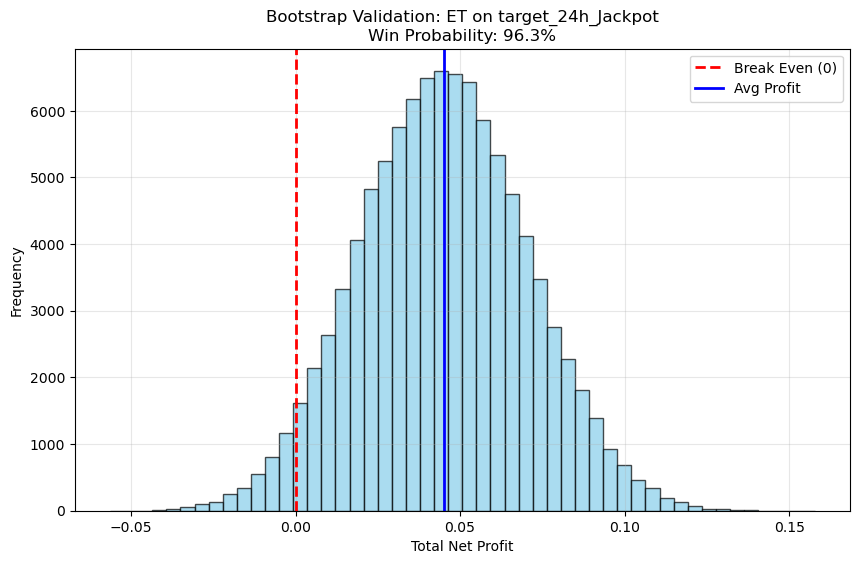

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ====================================================
# [설정] 검증하고 싶은 타겟과 모델
# 아까 1등 했던 그 조합을 여기에 적으세요.
# ====================================================
TARGET_FILE = "cusum_test_30_last_(purge적용)/log_24h_Jackpot.csv"  # 로그 파일 경로 (확인 필요)
TARGET_LABEL = "target_24h_JackPot"   # 로그 파일 안의 'Target' 컬럼 값
TARGET_MODEL = "ET"                 # 로그 파일 안의 'Model' 컬럼 값 (ExtraTrees)

def verify_specific_strategy(file_path, target_label, target_model, n_simulations=100000):
    # 1. 파일 로드
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f" 파일을 찾을 수 없습니다: {file_path}")
        return

    sub_df = df[ (df['Model'] == target_model) & (df['Target'] == target_label) ]
    
    # 데이터 확인
    if sub_df.empty:
        print(f" 해당 조건의 거래 내역이 없습니다.")
        print(f"   - 파일 내 모델 목록: {df['Model'].unique()}")
        print(f"   - 파일 내 타겟 목록: {df['Target'].unique()}")
        return

    returns = sub_df['NetProfit'].values
    n_trades = len(returns)
    
    print(f"\n===================================================")
    print(f" 전략 검증: [{target_model}] - [{target_label}]")
    print(f" 총 거래 횟수: {n_trades}회")
    print(f" 누적 수익률: {returns.sum() * 100:.2f}%")
    print(f"===================================================")

    if n_trades < 10:
        print(" 거래 횟수가 너무 적어서 부트스트래핑이 의미가 없습니다.")
        return

    # 3. 부트스트래핑
    print(f" 시뮬레이션 {n_simulations}회 수행 중...")
    
    profits = []
    sharpes = []
    
    for _ in range(n_simulations):
        # 복원 추출
        sim_rets = np.random.choice(returns, size=n_trades, replace=True)
        
        # 수익 합계
        profits.append(sim_rets.sum())
        
        # 샤프 (t-stat 유사)
        if np.std(sim_rets) == 0: sr = 0
        else: sr = np.mean(sim_rets) / np.std(sim_rets) * np.sqrt(n_trades)
        sharpes.append(sr)
        
    profits = np.array(profits)
    win_prob = (profits > 0).mean() * 100
    avg_profit = profits.mean()
    
    # 4. 결과 출력
    print(f"\n [검증 결과 Report]")
    print(f" 수익 확률 (P > 0): {win_prob:.2f}%  <-- 가장 중요!")
    print(f" 평균 예상 수익: {avg_profit * 100:.2f}%")
    print(f"  평균 샤프 지수: {np.mean(sharpes):.4f}")
    
    # 5. 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(profits, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Break Even (0)')
    plt.axvline(avg_profit, color='blue', linestyle='-', linewidth=2, label='Avg Profit')
    plt.title(f"Bootstrap Validation: {target_model} on {target_label}\nWin Probability: {win_prob:.1f}%")
    plt.xlabel("Total Net Profit")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 실행
if __name__ == "__main__":
    verify_specific_strategy(
        "cusum_test_30_last_(purge적용)/log_24h_Jackpot.csv", 
        "target_24h_Jackpot",                      
        "ET"                                 
    )
